In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import re
import seaborn as sns
from math import radians, sin, cos, asin, sqrt
import imageio
import os
from IPython.display import Image, display
import time
from scipy.stats import gaussian_kde
from statistics import mean
import statistics
import random

In [9]:
plotdir = 'plots/'

In [10]:
Ms = 10 #number of importance samples
CHR = 2
tCutoff = 'None'
samples_cont = range(278*2)
total_loci = 51846
max_allowed_locus = 51398  # Filter threshold
num_ancestor = 1000
ancestor_loci = list(np.linspace(0, total_loci - 1, num=num_ancestor, dtype=int))
ancestor_loci = [locus for locus in ancestor_loci if locus != 0 and locus < max_allowed_locus]

In [11]:
dispersal_cont = np.loadtxt("data/SGDP_contemporary_only_chr2_10M_NoneT.sigma", delimiter=',')
dispersal_cont = dispersal_cont.reshape(2, 2)  # 2×2 covariance matrix
print(dispersal_cont)

[[9.30577759e-01 2.66012846e+00]
 [6.67905689e-02 1.06917198e-03]]


In [3]:
#Loading all the loci to get the mean later
pattern_cont = 'data/SGDP_contemporary_only_chr2_*locus_10M_NoneT_Alls_Allt.locs'

fns = sorted(glob.iglob(pattern_cont))
starts = [int(re.search(r'chr2_(\d+)locus', fn).group(1)) for fn in fns]
locus_order = np.argsort(starts)
fnss_0 = [fns[i] for i in locus_order]
fnss_0.pop(0) # First locus is older version dont want it

# anc_locs_0 = []
# for i,fns in enumerate(fnss_0):
#     anc_loc = np.loadtxt(fns, delimiter=',')
#     anc_locs_0.append(anc_loc)

# anc_locs_0 = np.array(anc_locs_0)
# anc_locs_0 = np.swapaxes(anc_locs_0,0,1)
# L, n, T, d = anc_locs_0.shape
# L, n, T, d 

anc_locs_0 = []
for i, fpath in enumerate(fnss_0):
    df = pd.read_csv(fpath, header=None, names=["sample", "time", "lat", "lon"])
    samples = sorted(df["sample"].unique())
    timepoints = sorted(df["time"].unique())

    n = len(samples)
    T = len(timepoints)

    if n * T != len(df):
        print(f"Skipping {fpath}: expected {n*T} rows but got {len(df)}")
        continue
    sample_map = {v: i for i, v in enumerate(samples)}
    time_map = {v: i for i, v in enumerate(timepoints)}

    # Map samples and times to indices
    s_idx = df["sample"].map(sample_map).values
    t_idx = df["time"].map(time_map).values

    # Pre-allocate array
    arr = np.full((n, T, 2), np.nan)

    # Fill lat/lon efficiently using broadcasting
    arr[s_idx, t_idx, 0] = df["lon"].values
    arr[s_idx, t_idx, 1] = df["lat"].values

    anc_locs_0.append(arr)

anc_locs_0 = np.array(anc_locs_0)  # shape: (L, n, T, 2)
print("Final shape:", anc_locs_0.shape)

anc_locs_cont = anc_locs_0

L, n, T, d = anc_locs_cont.shape
L, n, T, d

Final shape: (989, 556, 10, 2)


(989, 556, 10, 2)

In [4]:
ancestor_times = list(np.logspace(np.log10(4), np.log10(40000), 10))

In [5]:
sample_locs_cont = np.loadtxt("data/SGDP_contemporary_only.locations")
sample_locs_cont= sample_locs_cont[:, [1, 0]] #Flip it so it transforms from lat-lon to lon-lat (same format as anc_locs)
print(sample_locs_cont.shape)

(556, 2)


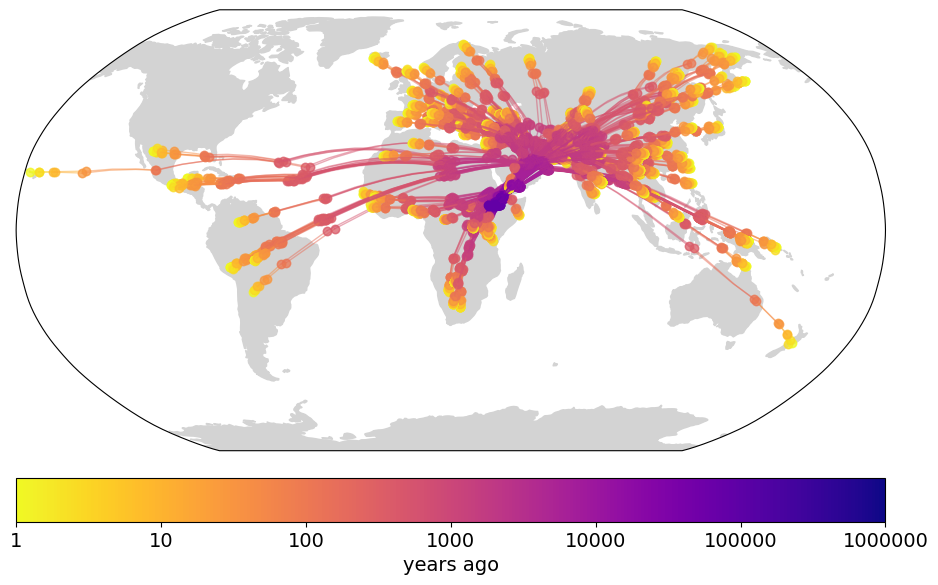

In [114]:
#plotting
fig = plt.figure(figsize=(10, 6), dpi=100, edgecolor='k')
projection = ccrs.Robinson(central_longitude=20)
data_crs = ccrs.PlateCarree() #data supplied in lat/long
geodetic = ccrs.Geodetic() #for great circles
ax = plt.axes(projection=projection)
ax.set_global()
ax.add_feature(cfeature.LAND, color='lightgray')
cmap = plt.get_cmap("plasma_r")

for sample in samples_cont: #samples: #for each sample
    # if (sample % 20 != 0):
    #     continue #Skip by 20 to thin num of samples
    #print(sample, "Population", df_poplabels["pop"][sample], " Group ", df_poplabels["group"][sample])
    # get mean ancestor location at all times
    mean_locs_cont = [sample_locs[sample]]
    # time_loc = locations[sample] #start with sample location
    for time_ix in range(T): #exclude late times as numerical issues
        locs = anc_locs_cont[:,sample,time_ix] #locations of all ancestors
        mean_loc = np.mean(locs, axis=0) #mean ancestor location       
        mean_locs_cont.append(mean_loc)
    mean_locs_cont = np.array(mean_locs_cont)


    # plot trajectory of mean ancestor colored by time
    for i in range(len(mean_locs_cont)-1):
        color = cmap(i / len(mean_locs_cont))
        x0,y0 = mean_locs_cont[i, 0], mean_locs_cont[i, 1]
        x1,y1 = mean_locs_cont[i+1, 0], mean_locs_cont[i+1, 1]

        if np.any(np.isnan([x0, y0, x1, y1])):
            continue
        ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=geodetic, marker='o') #great circles
        # ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=data_crs) #straight lines

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
# cbar.set_ticks([i/4 for i in range(5)])
# cbar.set_ticklabels(np.round(np.logspace(1,np.log10(ancestor_times[time_ix]),5)*25).astype(int).tolist())
ts = [10**i for i in range(7)]
cbar.set_ticks(np.log10(ts)/np.log10(ancestor_times[time_ix]*25)) #gen time = 25 years
cbar.set_ticklabels(ts)
cbar.set_label(('years ago'), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(plotdir + 'wohns_4b.png')
plt.show()

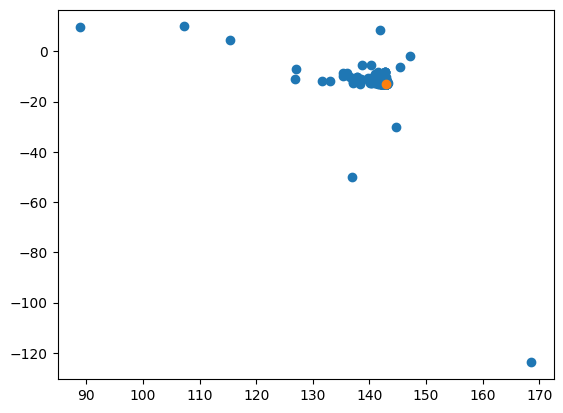

In [13]:
plt.scatter(anc_locs_cont[:, 0, 0, 0],anc_locs_cont[:, 0, 0, 1])
plt.scatter(sample_locs_cont[0,0], sample_locs_cont[0,1])